# HW2: The Challenger Accident
By: Tighe Clough

In [99]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import calendar
import seaborn as sns

#Functions

def haversine(lat1, lon1, lat2, lon2):
    """Finds distance between two coordinates on Earth Surface, uses vectorization
    
    Args:
        lat1 (float): lattitude of first coordinate
        lon1 (float): longitude of first coordinate
        lat2 (float): lattitude of second coordinate
        lon2 (float): longitude of second coordinate
        
    Returns:
        dis (float): distance between the two coordinates
    """
    
    #Sourced from https://engineering.upside.com/a-beginners-guide-to-optimizing-pandas-code-for-speed-c09ef2c6a4d6
    
    # radius of Earth (Km
    R = 6371
    
    # Converts to radians
    lat1, lon1, lat2, lon2 = map(np.deg2rad, [lat1, lon1, lat2, lon2])
    
    # Calculate differences for cleaner evaluation
    dlat = lat2 - lat1 
    dlon = lon2 - lon1 
    
    # Haversine formula
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    dis = R * c
    return dis


def inv_dis_temp_yr_df(lat0, long0, geo_df, temp_df, station_range):
    """Finds inverse distance weighted temperature at a certain coordinate location for entire year
    using data from all stations within certain range of that location, given a station location dataframe and station temperature dataframe, 
    returns whole dataframe
    
    Args:
        lat0 (float): lattitude of coordinate that you want to find the temperature for
        long0 (float): longitude of coordinate that you want to find the temperature for
        geo_df (pandas.DataFrame): dataframe containing columns 
            "station_id" - the id of the weather station 
            "gps_lat" - the lattitude of the weather station
            "gps_long" - the longitude of the weather station
        temp_df (pandas.DataFrame): dataframe containing columns
            "station_id" - the id of the weather station 
            "month" - month of temperature measure
            "day" - day of temperature measure
            "temp" - temperature
    Returns:
        grouped (pandas.DataFrame): dataframe with inverse distance weighted temperature of given coordinate on certain date
            
    """
    
    # find distances from point to each station
    geo_df['haversine_km'] = haversine(geo_df.gps_lat, geo_df.gps_long, lat0, long0)
    
    # merge dataframe into one master
    master = temp_df.merge(stations[['station_id','haversine_km']],on='station_id')

    # filter within range
    close = master[master.haversine_km < station_range].copy() #deep copy to avoid SettingWithCopyWarning

    # calculate inverse distance weighted temperature
    close['inv_dist'] = 1 / (close.haversine_km ** 2)
    close['weighted'] = close.temp * close.inv_dist

    grouped = close.groupby(['month','day']).sum()[['inv_dist', 'weighted']]
    grouped['final'] = grouped.weighted / grouped.inv_dist
    
    return grouped

def cc_plot_temp(grouped_df, temp_series):
    """Graphs temperatures (in this case for 1986 for Cape Canaveral, Florida) using an input grouped 
    dataframe multi-indexed by month and day and the column name of the temp series
    
    Args:
        "grouped_df" (pandas.DataFrame) - dataframe with multindexed month and day 
        and a column containing the temperature for each day
        "temp_series" (string) - column name containing temeperatures 
    """
    
    # Create plot
    temp_plot = grouped_df.plot(figsize = (10,5), 
                         use_index=True, y=temp_series, 
                         xlabel = 'Date', ylabel='Temperature (°F)', 
                         title='Cape Canaveral Temperatures in 1986', grid = True, color = 'slategrey')

    # plot ticks based on day in year - 1, (indexing changed when plotted to day # if year)
    # calculate x ticks location through taking lengths of month and adding
    month_lengths = [0] + [len(grouped.loc[x]) for x in range(1,12)]
    month_starts = [sum(month_lengths[0:y]) for y in range(1,len(month_lengths)+1)] 
    
    temp_plot.set_xticks(month_starts)
    temp_plot.set_xticklabels(calendar.month_abbr[1:13])
    
    # Annotate to show date of challenger launch
    plt.annotate(text="January 28, Challenger launch (36.86°F ≈ 2.7°C)", 
                 fontsize=15,
                 xy=(28,37), xytext=(60,36), 
                 arrowprops={"width":1,"headwidth":5})
    
    plt.show()

def inv_dis_temp(lat0, long0, geo_df, temp_df, station_range, m_d_tuple):
    """Finds inverse distance weighted temperature at a certain coordinate location
    for all stations within a range given a station location dataframe and station temperature dataframe, 
    returns temperature if specified
    
    Args:
        lat0 (float): lattitude of coordinate that you want to find the temperature for
        long0 (float): longitude of coordinate that you want to find the temperature for
        geo_df (pandas.DataFrame): dataframe containing columns 
            "station_id" - the id of the weather station 
            "gps_lat" - the lattitude of the weather station
            "gps_long" - the longitude of the weather station
        temp_df (pandas.DataFrame): dataframe containing columns
            "station_id" - the id of the weather station 
            "month" - month of temperature measure
            "day" - day of temperature measure
            "temp" - temperature
        station_range (float): radius contraint from given coordinate encircling stations to be used in temperature calculations for coordinate 
        m_d_tuple (tuple): tuple with format (month#, day#) to specify given date for visualization
    Returns:
        temp (float): temperature at coordinate
    
    """
    
    # filter to correct day of the year
    m, d = m_d_tuple
    temp_df = temp_df[(temp_df.month==m) & (temp_df.day==d)]
    
    # find distances for each station
    geo_df['haversine_km'] = haversine(geo_df.gps_lat, geo_df.gps_long, lat0, long0)
    
    # filter to close stations
    geo_df = geo_df[geo_df.haversine_km < station_range]
    
    # merge dataframe into one master
    master = temp_df.merge(geo_df[['station_id','haversine_km']],on='station_id')
    
    # calculate inverse distance weighted temperature
    master['inv_dist'] = 1 / (master.haversine_km ** 2)
    master['weighted'] = master.temp * master.inv_dist

    temp = sum(master.weighted) / sum(master.inv_dist)
    
    return temp

def vis_temp(geo_df, temp_df, num_longs, num_lats, lon_left, lon_right, lat_bot, lat_top, station_range, m_d_tuple):
    """visualizes temperatures for a given day over a certain coordinate range
    
      Args:
        geo_df (pandas.DataFrame): dataframe containing columns 
            "station_id" - the id of the weather station 
            "gps_lat" - the lattitude of the weather station
            "gps_long" - the longitude of the weather station
        temp_df (pandas.DataFrame): dataframe containing columns
            "station_id" - the id of the weather station 
            "month" - month of temperature measure
            "day" - day of temperature measure
            "temp" - temperature
        num_longs (int): amount of logitudinal coordinates
        num_lats (int): amount of lattitudinal coordinates
        lon_left (float): Western longitude bound
        lon_left (float): Eastern longitude bound
        lat_bot (float): Southern lattitude bound
        lat_top (float): Northern lattitude bound
        station_range (float): radius contraint from given coordinate encircling stations to be used in temperature calculations for coordinate 
        m_d_tuple (tuple): tuple with format (month#, day#) to specify given date for visualization
    """
    
    # create coordinate array 
    # meshgrid where each coordinate point is represented by longitude in first array and lattitude in array "behind"
    # coordinates line up through third axis
    # meshgrid points are oriented appropriately
    point_longs = np.linspace(lon_left, lon_right, num_longs)
    point_lats = np.linspace(lat_top, lat_bot, num_lats)
    
    coord_array = np.array(np.meshgrid(point_longs, point_lats))
    
    # make a color key
    color_key = sns.color_palette("coolwarm", n_colors=14)
    
    # color array to store color
    image = np.zeros((num_lats,num_longs,3), dtype=float)
    
    # calculate the temperature and store rgb values
    # giving me the index positon
    for x in range(num_longs):
        for y in range(num_lats):
            long0, lat0 = coord_array[:,y,x]
            try:
                point_temp = inv_dis_temp(lat0, long0, geo_df, temp_df, stat_range, m_d_tuple)
                color_num = int(point_temp // 10) + 2 #buckets for every 10 degrees
                image[y,x] = color_key[color_num]
            except:
                pass
    
    month, day = m_d_tuple
    m_str = calendar.month_abbr[month]
    
    # load in map with correct coordinates
    usa_map = mpimg.imread('data/usa_map3.png')
    
    # visualize temperature map
    plt.figure(figsize=(10,10))
    plt.imshow(usa_map, extent=[0,num_longs,num_lats,0], alpha=.5)
    plt.imshow(image, interpolation = 'gaussian', alpha=.8)

    plt.title(f'{m_str} {day},1986 USA Temperature Map')
    plt.xlabel('Longitude')
    plt.xticks(range(0,num_longs,10), [round(x,1) for x in point_longs[::10]], rotation='45')
    plt.ylabel('Latitude')
    plt.yticks(range(0,num_lats,10), [round(x,1) for x in point_lats[::10]])
    plt.show()
    
def create_vec_df(geo_df, temp_df, m_d_tuple):
    """Creates master dataframe for all stations incorporating coordinates and temp for a given day"""
    m, d = m_d_tuple
    temp_df = temp_df[(temp_df.month==m) & (temp_df.day==d)]
    
    vec_df = temp_df.merge(geo_df[['station_id','gps_lat','gps_long']],on='station_id')
    
    return vec_df

### Some Manipulation to the Data

In [38]:
# read the data
temp_df = pd.read_csv('data/temp_1986.csv', names = ['station_id', 'wban_id', 'month', 'day', 'temp'])
geo_df = pd.read_csv('data/stations.csv', names = ['station_id', 'wban_id', 'gps_lat', 'gps_long'])

# don't need wban id
temp_df = temp_df.drop('wban_id', 1)
geo_df = geo_df.drop('wban_id',1)

# get rid of nan stations
temp_df = temp_df.dropna()
geo_df = geo_df.dropna()

# get rid of invalid coordinates
geo_df = geo_df[(geo_df.gps_lat != 0) & (geo_df.gps_long != 0)]

# Cape Canaveral Coordinates
CC_LAT = 28.396837
CC_LONG = -80.605659

# range(km) constraint
ST_RANGE = 100

grouped_df = inv_dis_temp_yr_df(CC_LAT, CC_LONG, geo_df, temp_df, ST_RANGE)

<h3>Temperature Graph</h3>

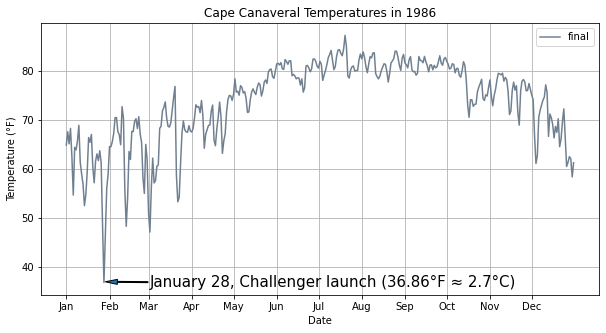

In [100]:
cc_plot_temp(grouped_df, 'final')

<h2> Part B: USA Visualize </h2>

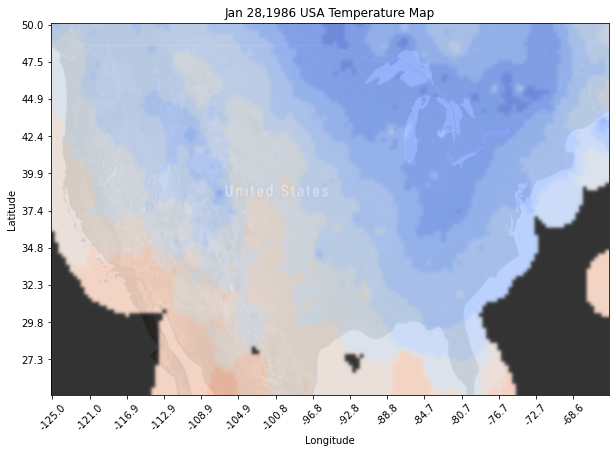

In [95]:
num_longs = 150
num_lats = 100
lon_left = -125
lon_right = -65
lat_bot = 25
lat_top = 50
station_range = 250

#Visualize January 28th Temperatures (Takes some time)
vis_temp(geo_df, temp_df, num_longs, num_lats, lon_left, lon_right, lat_bot, lat_top, station_range, (1,28))

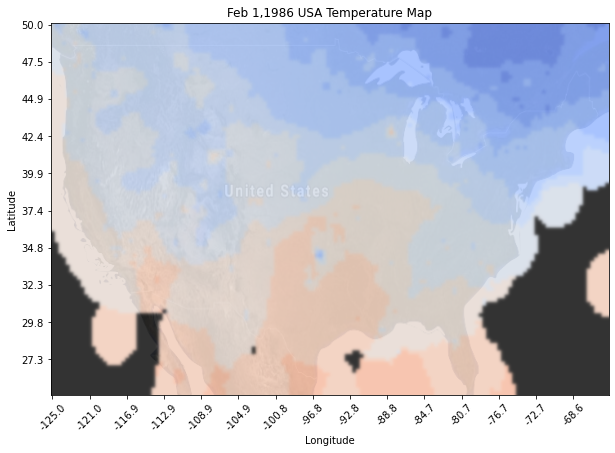

In [177]:
# Visualize February 1st Temperatures
vis_temp(geo_df, temp_df, num_longs, num_lats, lon_left, lon_right, lat_bot, lat_top, stat_range, (2,1))